# Knowledge distillation
Suppose that we have a large network (*teacher network*) or an ensemble of networks which has a good accuracy but doesn't fit into memory/runtime requirements. Instead of training a smaller network (*student network*) directly on the original dataset, we can train this network to predict outputs of teacher networks. It turns out that the perfomance could be even better! This approach doesn't help with training speed, but can be quite beneficial when we'd like to reduce the model size for low-memory devices.

* https://www.ttic.edu/dl/dark14.pdf
* [Distilling the Knowledge in a Neural Network](https://arxiv.org/abs/1503.02531)
* https://medium.com/neural-machines/knowledge-distillation-dc241d7c2322

Even the completely different ([article](https://arxiv.org/abs/1711.10433)) architecture can be used in a student model, e.g. you can approximate an autoregressive model (WaveNet) by a non-autoregressive one.

# Подготовка данных и train loop

In [1]:
import torch
import torchvision
from torchvision import transforms
import tqdm


device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

In [2]:
train_trainsforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomRotation(5),
    transforms.ColorJitter()
])

In [3]:
import tiny_img_dataset


train_dataset = tiny_img_dataset.TinyImagenetRAM('tiny-imagenet-200/train', transform=train_trainsforms)

tiny-imagenet-200/train: 100%|████████████████| 200/200 [00:14<00:00, 13.56it/s]


In [4]:
import os
from PIL import Image
from torch.utils.data import Dataset


class TinyImagenetValDataset(Dataset):
    def __init__(self, root, transform=transforms.ToTensor()):
        super().__init__()

        self.root = root
        with open(os.path.join(root, 'val_annotations.txt')) as f:
            annotations = []
            for line in f:
                img_name, class_label = line.split('\t')[:2]
                annotations.append((img_name, class_label))

        self.classes = sorted(list({class_label for _, class_label in annotations}))
        self.class_to_idx = {item: index for index, item in enumerate(self.classes)}

        self.transform = transform

        self.images, self.targets = [], []
        for img_name, class_name in tqdm.tqdm(annotations, desc=root):
            img_name = os.path.join(root, 'images', img_name)
            image = tiny_img_dataset.read_rgb_image(img_name)

            self.images.append(Image.fromarray(image))
            self.targets.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.transform(self.images[index])
        target = self.targets[index]

        return image, target

In [5]:
val_dataset = TinyImagenetValDataset('tiny-imagenet-200/val', transform=transforms.ToTensor())

tiny-imagenet-200/val: 100%|████████████| 10000/10000 [00:01<00:00, 6786.04it/s]


In [6]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=12)

val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=12)

In [7]:
def compute_loss(logits, gt):
    return F.cross_entropy(logits, gt).mean()

In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline


def eval_model(model, data_generator):
    accuracy = []
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)


def train_model(model, optimizer, train_data_generator):
    train_loss = []
    model.train()
    for (X_batch, y_batch) in train_data_generator:
        opt.zero_grad()
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predictions = model(X_batch)
        loss = compute_loss(predictions, y_batch)

        loss.backward()
        optimizer.step()

        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


def train_loop(model, name_model, optimizer, train_data_generator, val_data_generator, num_epochs):
    """
    num_epochs - total amount of full passes over training data
    """
    
    max_val_accuracy = -1
    metrics = {'train_loss': [], 'val_accuracy': [] }
    
    for epoch in tqdm.tqdm(range(num_epochs)):
        step = len(metrics['train_loss']) + 1
        
        start_time = time.time()

        train_loss = train_model(model, optimizer, train_data_generator)
        val_accuracy = eval_model(model, val_data_generator)

        clear_output(True)
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))

        metrics['train_loss'].append((step, train_loss))
        metrics['val_accuracy'].append((step, val_accuracy))

        if metrics["val_accuracy"][-1][1] > max_val_accuracy:
            max_val_accuracy = metrics["val_accuracy"][-1][1]
            torch.save(model, f'{name_model}.pth')


        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()

    return metrics

# Task
## 1. Teacher network
Train good enough (teacher) network, achieve >=35% accuracy on validation set of Tiny Imagenet (you can reuse any network from homework part 1 here).

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [10]:
class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return torch.mean(x, dim=self.dim)

    
class ConvBNRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        super().__init__()      

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        return x

    
def create_vgg_like_network(config=None):
    """
    Creates VGG like network according to config
    """
    model = nn.Sequential()
    
    default_config = [[16,16], [32, 32], [64, 64], [128, 128]]
    config = config or default_config
    
    in_channels = 3
    for block_index in range(len(config)):
        for layer_index_in_block in range(len(config[block_index])):
            out_channels = config[block_index][layer_index_in_block]
            
            model.add_module(f'ConvBNRelu_{block_index}_{layer_index_in_block}', ConvBNRelu(in_channels, out_channels, kernel_size=3))
            
            in_channels = out_channels
            
        if block_index != len(config) - 1:
            model.add_module(f'mp_{block_index}', nn.LPPool2d(2, 3, stride=2))
            
    model.add_module('pool', GlobalAveragePool(dim=(2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

In [11]:
teacher_network = create_vgg_like_network().to(device)
opt = torch.optim.Adam(teacher_network.parameters())

Epoch 12 of 12 took 22.993s
  training loss (in-iteration): 	2.351173
  validation accuracy: 			37.84 %


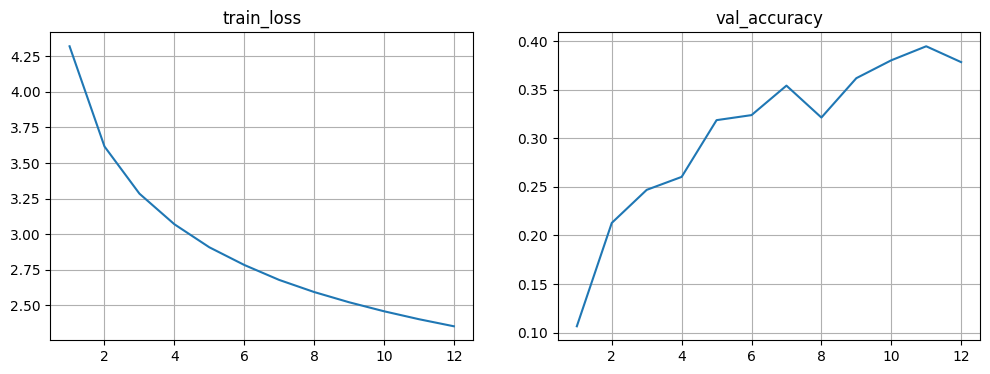

100%|███████████████████████████████████████████| 12/12 [04:40<00:00, 23.37s/it]


In [12]:
metrics_teacher_network = train_loop(teacher_network, "teacher_network" , opt, train_batch_gen, val_batch_gen, num_epochs=12)

In [13]:
teacher_network = torch.load("teacher_network.pth").eval()
val_accuracy = eval_model(teacher_network, val_batch_gen)

print(f'val_accuracy: {round(val_accuracy * 100, 4)}')

val_accuracy: 39.4705


## 2. Student network 
Train small (student) network, achieve 20-25% accuracy, draw a plot "training and testing errors vs train step index"

In [14]:
class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return torch.mean(x, dim=self.dim)


class StudentNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_1 =  nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
        )

        self.sequential_2 =  nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
        )

        self.global_average_pool = GlobalAveragePool((2, 3))
        self.linear = nn.Linear(in_features=64, out_features=200)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, input):
        out_sequential_1 = self.sequential_1(input)
        out_sequential_2 = self.sequential_2(out_sequential_1)
        
        out_global_pool = self.global_average_pool(out_sequential_2)
        logits = self.linear(out_global_pool)
        
        return logits


In [15]:
student_network = StudentNetwork().to(device)
opt = torch.optim.Adam(student_network.parameters())

Epoch 20 of 20 took 9.225s
  training loss (in-iteration): 	3.568722
  validation accuracy: 			20.72 %


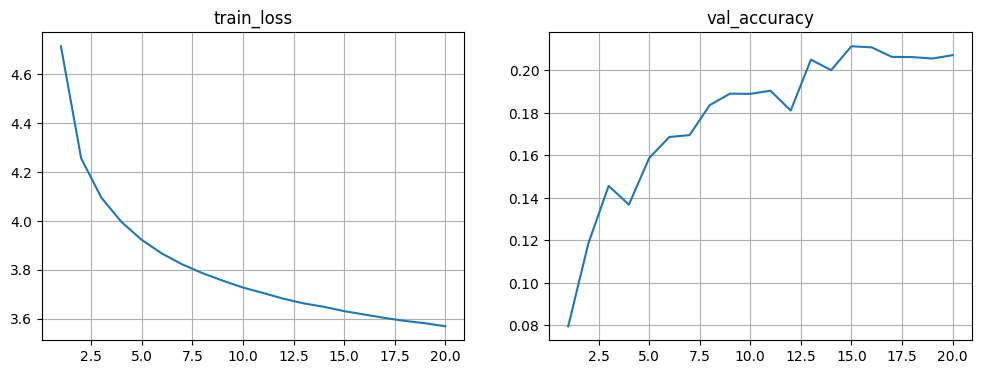

100%|███████████████████████████████████████████| 20/20 [03:06<00:00,  9.33s/it]


In [16]:
metrics_student_network = train_loop(student_network, "student_network", opt, train_batch_gen, val_batch_gen, num_epochs=20)

In [25]:
student_network = torch.load("student_network.pth").eval()
val_accuracy = eval_model(student_network, val_batch_gen)

print(f'val_accuracy: {round(val_accuracy * 100, 4)}')

val_accuracy: 21.1385


## 3. Knowledge distillation
![image info](https://miro.medium.com/max/875/1*WxFiH3XDY1-28tbyi4BGDA.png)

At this block you will have to retrain your student network using "knowledge distillation" technique. **Distill teacher network with student network, achieve at least +1% improvement in accuracy over student network accuracy.**

The training procedure is the same as for training the student network from scratch except the loss formulation.

Assume that 
- $z_i$ are logits predicted by the student network at the current step for an input image
- $v_i$ are logits predicted by the (freezed) teacher network
- $y_i$ are one-hot encoded label of the input image
- $p_i = \frac{\exp{z_i}}{\sum_j \exp{z_j}}$ - logits $z_i$ after sofrmax
- $q_i = \frac{\exp{\frac{z_i}{T}}}{\sum_j \exp{\frac{z_j}{T}}}$, where $T$ is softmax temperature
- $r_i = \frac{\exp{\frac{v_i}{T}}}{\sum_j \exp{\frac{v_j}{T}}}$, where $T$ is the same softmax temperature as for $q_i$

The loss for knowledge distillation: $$-\sum_i y_i \log p_i - \alpha \sum_i r_i \log q_i$$

$T$ and $\alpha$ are hyperparameters. 

- There is a good practice of using softmax with high temperature to obtain "soft" distributions, you can start with $T=10$. Check the [post](https://medium.com/mlearning-ai/softmax-temperature-5492e4007f71) with good visualizations on how the temperature affects the softmax output. 
- For $\alpha$ there is the following note in the original [paper](https://arxiv.org/pdf/1503.02531.pdf):

> Since the magnitudes of the gradients produced by the soft targets scale as $1/T^2$ it is important to multiply them by $T^2$ when using both hard and soft targets. This ensures that the relative contributions of the hard and soft targets remain roughly unchanged if the temperature used for distillation is changed while experimenting with meta-parameters.

In [18]:
def compute_loss(probs, gt):
    return -(gt * torch.log(probs)).sum()
    

In [19]:
import time
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline


def knowledge_distillation_train_model(teacher_network, student_network, optimizer, train_data_generator, alpha=1, temperature=1):
    train_loss = []
    student_network.train()
    for (X_batch, y_batch) in train_data_generator:
        opt.zero_grad()
        
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        gt_one_hot = F.one_hot(y_batch, num_classes=200)
        
        logits_teacher = teacher_network(X_batch)
        logits_student = student_network(X_batch)

        probs_student = torch.softmax(logits_student, dim=1)
        probs_teacher_with_temperature = torch.softmax(logits_teacher / temperature, dim=1)
        probs_student_with_temperature = torch.softmax(logits_student / temperature, dim=1)        
               
        loss_hard = compute_loss(probs_student, gt_one_hot)
        loss_distillation = compute_loss(probs_student_with_temperature, probs_teacher_with_temperature)
        
        loss = loss_hard + alpha * loss_distillation
        
        loss.backward()
        optimizer.step()

        train_loss.append(loss.cpu().data.numpy())

    return np.mean(train_loss)


def knowledge_distillation_train_loop(teacher_network, student_network, name_model, optimizer, train_data_generator, val_data_generator, num_epochs, alpha=1, temperature=1):
    max_val_accuracy = -1
    metrics = {'train_loss': [], 'val_accuracy': [] }
    for epoch in tqdm.tqdm(range(num_epochs)):
        step = len(metrics['train_loss']) + 1

        start_time = time.time()

        train_loss = knowledge_distillation_train_model(teacher_network, student_network, optimizer, train_data_generator, alpha, temperature)
        val_accuracy = eval_model(student_network, val_data_generator)

        clear_output(True)

        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_accuracy * 100))

        metrics['train_loss'].append((step, train_loss))
        metrics['val_accuracy'].append((step, val_accuracy))

        if metrics["val_accuracy"][-1][1] > max_val_accuracy:
            max_val_accuracy = metrics["val_accuracy"][-1][1]
            torch.save(student_network, f'{name_model}.pth')


        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()

    return metrics


In [20]:
teacher_network = torch.load('teacher_network.pth').eval()
student_network = StudentNetwork().to(device)

opt = torch.optim.Adam(student_network.parameters())

Epoch 40 of 40 took 25.497s
  training loss (in-iteration): 	33896.410156
  validation accuracy: 			22.02 %


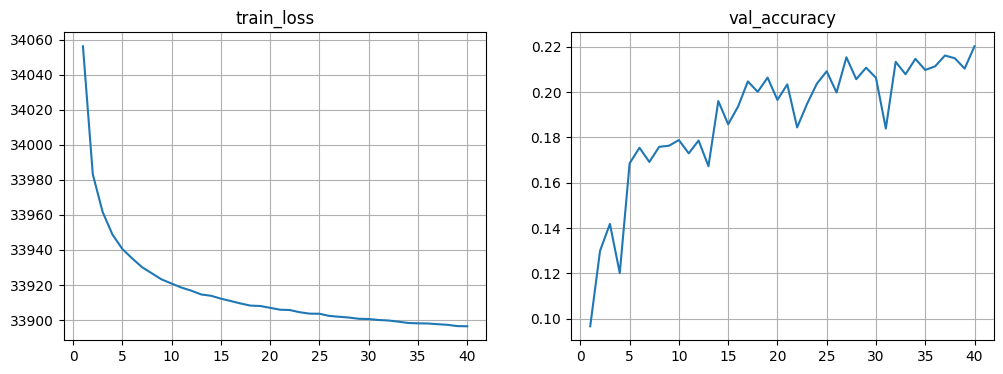

100%|███████████████████████████████████████████| 40/40 [17:07<00:00, 25.68s/it]


In [21]:
temperature = 10
alpha = temperature ** 2

metrics_student_network = knowledge_distillation_train_loop(
    teacher_network, 
    student_network, 
    "student_network_distillation", 
    opt, 
    train_batch_gen, 
    val_batch_gen,
    num_epochs=40,
    alpha=alpha,
    temperature=temperature,
)

Epoch 20 of 20 took 25.466s
  training loss (in-iteration): 	431.432953
  validation accuracy: 			23.95 %


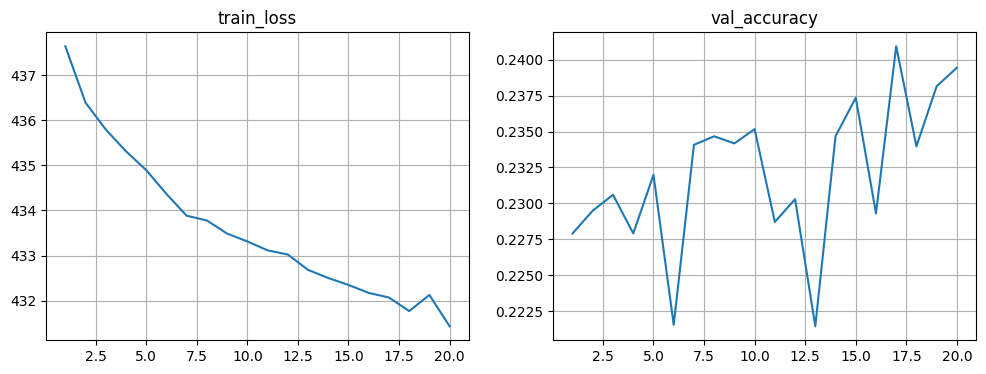

100%|███████████████████████████████████████████| 20/20 [08:32<00:00, 25.63s/it]


In [22]:
temperature = 5
alpha = 0.65

metrics_student_network = knowledge_distillation_train_loop(
    teacher_network, 
    student_network, 
    "student_network_distillation", 
    opt, 
    train_batch_gen, 
    val_batch_gen,
    num_epochs=20,
    alpha=alpha,
    temperature=temperature,
)

In [24]:
student_network = torch.load("student_network_distillation.pth").eval()
val_accuracy = eval_model(student_network, val_batch_gen)

print(f'val_accuracy: {round(val_accuracy * 100, 4)}')

val_accuracy: 24.0943


In [33]:
student_network = torch.load("student_network.pth").eval()
student_network_distillation = torch.load("student_network_distillation.pth").eval()

val_accuracy = eval_model(student_network, val_batch_gen)
val_accuracy_distillation = eval_model(student_network_distillation, val_batch_gen)

print(round((val_accuracy_distillation - val_accuracy) * 100, 4))

2.9558


Модель ученик стала на почти на 3 процента лучше

**Final notes**:
- Please, don't cheat with early-early-early stopping while training of the student network. Make sure, it  converged.
- Logits still carry more information than the probabilities after softmax.
- Don't forget to use your teacher network in 'eval' mode. And don't forget your main objective.

**Future readings**
- ["Born again neural networks"](https://arxiv.org/pdf/1805.04770.pdf) - knowledge distillation may give benefits even when teacher and student networks have the same architecture.
- ["Prune your model before distill it"](https://arxiv.org/pdf/2109.14960.pdf) - pruning of the teacher model before distillation may improve quality of student model